# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [ ]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [ ]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [ ]:
# Display the first 1000 characters of the dataset
print("First 1000 characters of the dataset:")
print(text[:1000])

# Report the dataset's size
dataset_size = len(text)
print("\nDataset size (number of characters):", dataset_size)

# Count the number of unique characters in the dataset
unique_characters = set(text)
num_unique_characters = len(unique_characters)
print("Number of unique characters:", num_unique_characters)

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Your code here

text = text.lower()

# Initialize the tokenizer with an OOV token
OOV_TOKEN = "<OOV>"
tokenizer = Tokenizer(oov_token=OOV_TOKEN)

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])

# Determine the size of the vocabulary
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 for the OOV token

# Convert text to sequences
sequences = tokenizer.texts_to_sequences([text])[0]

# Print some information about the tokenization
print("Vocabulary Size:", VOCAB_SIZE)
print("First 20 tokens in the sequence:", sequences[:20])
try:
    print("Word Index (first 10 words):", dict(list(tokenizer.word_index.items())[:10]))
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)



Vocabulary Size: 746
First 20 tokens in the sequence: [316, 103, 103, 317, 219, 17, 36, 220, 84, 17, 55, 57, 55, 17, 51, 57, 51, 17, 221, 318]
Word Index (first 10 words): {'<OOV>': 1, 'github': 2, 'script': 3, 'defer': 4, 'js': 5, 'com': 6, 'https': 7, 'assets': 8, 'githubassets': 9, 'crossorigin': 10}


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [ ]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('github', 2), ('script', 3), ('defer', 4), ('js', 5), ('com', 6), ('https', 7), ('assets', 8), ('githubassets', 9), ('crossorigin', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [ ]:
import numpy as np

# Define sequence length
SEQ_LENGTH = 50  # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []

for i in range(SEQ_LENGTH, len(sequences)):
    sequence_extract = sequences[i-SEQ_LENGTH:i]
    target = sequences[i]

    # Append to the lists
    X.append(sequence_extract)
    y.append(target)

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

print("First input sequence:", X[0])
print("First target word index:", y[0])
print("First target word:", tokenizer.index_word[y[0]])


Shape of X: (3611, 50)
Shape of y: (3611,)
First input sequence: [316 103 103 317 219  17  36 220  84  17  55  57  55  17  51  57  51  17
 221 318 222 319  17 221  24 320  52 172  15 321 322 223  24  28 125 126
  25   7   2   9   6  24  28 125 126  25   7 224 173   6]
First target word index: 24
First target word: link


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [ ]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [316 103 103 317 219  17  36 220  84  17  55  57  55  17  51  57  51  17
 221 318 222 319  17 221  24 320  52 172  15 321 322 223  24  28 125 126
  25   7   2   9   6  24  28 125 126  25   7 224 173   6]
Target: 24
Translated back to words: ['doctype', 'html', 'html', 'lang', 'en', 'data', 'color', 'mode', 'auto', 'data', 'light', 'theme', 'light', 'data', 'dark', 'theme', 'dark', 'data', 'a11y', 'animated', 'images', 'system', 'data', 'a11y', 'link', 'underlines', 'true', 'head', 'meta', 'charset', 'utf', '8', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'github', 'githubassets', 'com', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'avatars', 'githubusercontent', 'com'] -> link


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (2888, 50)
y_train shape: (2888, 746)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

# Define model parameters
EMBEDDING_DIM = 100  # Size of word vectors
LSTM_UNITS = 150     # Number of units in the LSTM layer

# Build the model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH),    # Embedding layer
    LSTM(units=LSTM_UNITS, return_sequences=False),  # LSTM layer
    Dense(units=VOCAB_SIZE, activation='softmax') #  Dense layer with softmax activation
])

dummy_input = np.zeros((1, SEQ_LENGTH), dtype=np.int32)
model(dummy_input)

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 50, 100)                │          74,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, 150)                    │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 746)                    │         112,646 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,846 (1.29 MB)

 Trainable params: 337,846 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

The Loss Function categorical_crossentrop measures the difference between the predicted probability distribution and the true distribution.
The Adam optimizer helps to make  effective  handling sparse gradients and non-stationary objectives.
Tracking accuracy helps to provide provides useful insights into the model's performance during training. It also monitor how often the model's predictions match the actual target.

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['accuracy']  # Track accuracy as an additional metric
)

# Print a summary to verify the compilation
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 50, 100)                │          74,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, 150)                    │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 746)                    │         112,646 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,846 (1.29 MB)

 Trainable params: 337,846 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(learning_rate=0.001),  
    metrics=['accuracy']  #
)

model.summary()

epochs = 70
batch_size = 128


history = model.fit(
    X_train,  # Training input sequences
    y_train,  # Training targets (one-hot encoded)
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=1  # Verbose mode for detailed output
)


Epoch 1/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8637 - loss: 0.7006 - val_accuracy: 0.5546 - val_loss: 3.2464
Epoch 2/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8743 - loss: 0.6839 - val_accuracy: 0.5505 - val_loss: 3.2379
Epoch 3/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8712 - loss: 0.6566 - val_accuracy: 0.5533 - val_loss: 3.2500
Epoch 4/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8796 - loss: 0.6351 - val_accuracy: 0.5519 - val_loss: 3.2641
Epoch 5/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8880 - loss: 0.6218 - val_accuracy: 0.5533 - val_loss: 3.2763
Epoch 6/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8962 - loss: 0.5802 - val_accuracy: 0.5546 - val_loss: 3.2716
Epoch 7/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8903 - loss: 0.5906 - val_accuracy: 0.5463 - val_loss: 3.2869
Epoch 8/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9035 - loss: 0.5587 - val_accuracy: 0.5505 - v




Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

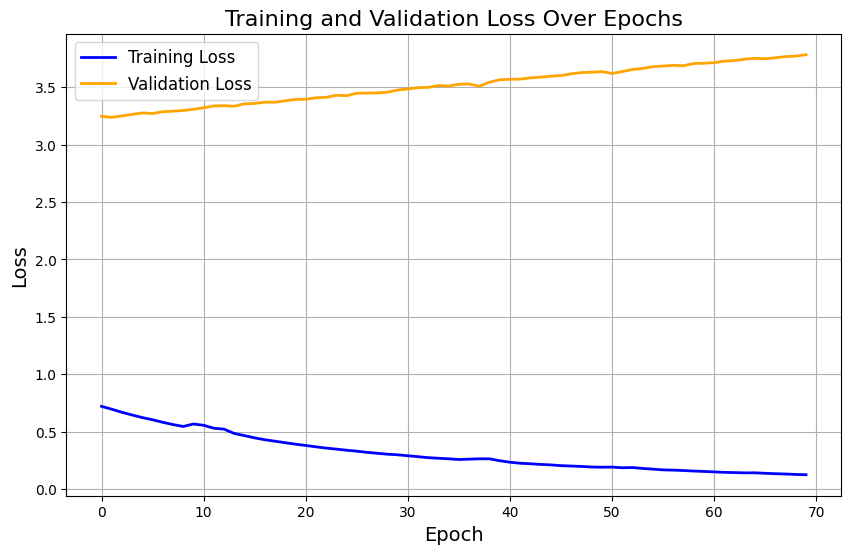

In [ ]:
import matplotlib.pyplot as plt

# Your code here

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


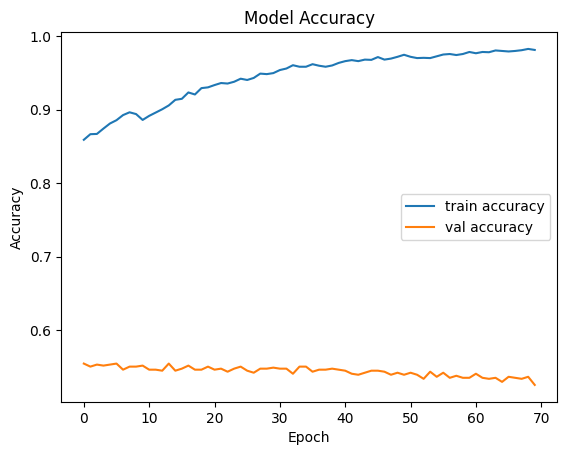

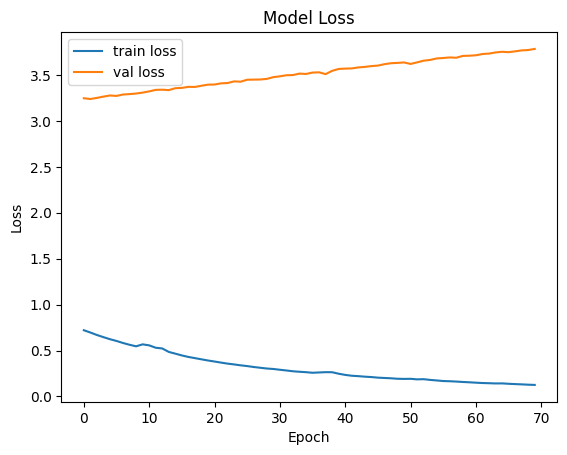

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence, temperature=1.0):
    """
    Get the predicted word from the model using temperature to add randomness.

    Args:
    - model: Trained RNN model.
    - sequence: The input sequence of tokens for prediction.
    - temperature: Float, controls randomness in predictions. Lower values make the model more deterministic.

    Returns:
    - The index of the predicted word.
    """
    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Apply temperature to the predictions
    yhat = np.asarray(yhat).astype('float64')
    yhat = np.log(yhat + 1e-9) / temperature  # Avoid log(0) with a small epsilon
    exp_preds = np.exp(yhat)
    yhat = exp_preds / np.sum(exp_preds)

    # Get the index of the predicted word, according to the probabilities
    predicted_index = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return predicted_index

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_tokens_to_generate=50, temperature=1.0):
    """
    Generate new text using the trained model.

    Args:
    - model: The trained RNN model.
    - tokenizer: The tokenizer used to preprocess the text data.
    - seed_text: The seed text the model will use to generate new text.
    - max_sequence_len: The maximum length of the sequence used to generate new text.
    - num_tokens_to_generate: Number of tokens to generate.
    - temperature: Float, controls randomness in predictions.

    Returns:
    - Generated text as a single string.
    """
    # Tokenize the seed text
    input_sequence = tokenizer.texts_to_sequences([seed_text])[0]

    # Initialize the result with the seed text
    generated_text = seed_text

    for _ in range(num_tokens_to_generate):
        input_sequence_padded = pad_sequences([input_sequence], maxlen=max_sequence_len, padding='pre')

        predicted_index = get_predicted_word(model, input_sequence_padded, temperature)

        predicted_word = tokenizer.index_word.get(predicted_index, '')

        generated_text += ' ' + predicted_word

        input_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]  # Remove the first token

        print(predicted_word, end=' ', flush=True)

    print() 
    return generated_text



In [ ]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

1 version 1 5 svg meta name octicon mark 5 896 dsi target aria 16 position lg 0 meta name path svg meta 0 d m12 0 path js header position relative 1 5 py 24 position relative left 0 version 1 flex m12 5 headermenu version 1 details height 


'hamlet 1 version 1 5 svg meta name octicon mark 5 896 dsi target aria 16 position lg 0 meta name path svg meta 0 d m12 0 path js header position relative 1 5 py 24 position relative left 0 version 1 flex m12 5 headermenu version 1 details height'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-04 17:08:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2024-08-04 17:10:58 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [ ]:
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [ ]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [ ]:
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU
import numpy as np

embedding_layer = Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=100,
    weights=[embedding_matrix],
    input_length=SEQ_LENGTH,
    trainable=False
)

model = Sequential([
    embedding_layer,
    GRU(256, return_sequences=True),
    Dropout(0.3),
    GRU(128),
    Dropout(0.3),
    Dense(VOCAB_SIZE, activation='softmax')
])

dummy_input = np.zeros((1, SEQ_LENGTH), dtype=np.int32)
model(dummy_input)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy', 'precision', 'recall']
)



In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)



Epoch 1/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.0491 - loss: 6.5303 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0954 - val_loss: 5.9130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0592 - loss: 5.7247 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1010 - val_loss: 5.3923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1053 - loss: 5.2747 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1286 - val_loss: 5.1227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1359 - loss: 4.9190 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1715 - val_loss: 4.8619 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2048 - loss: 4.6013 - precision: 0.

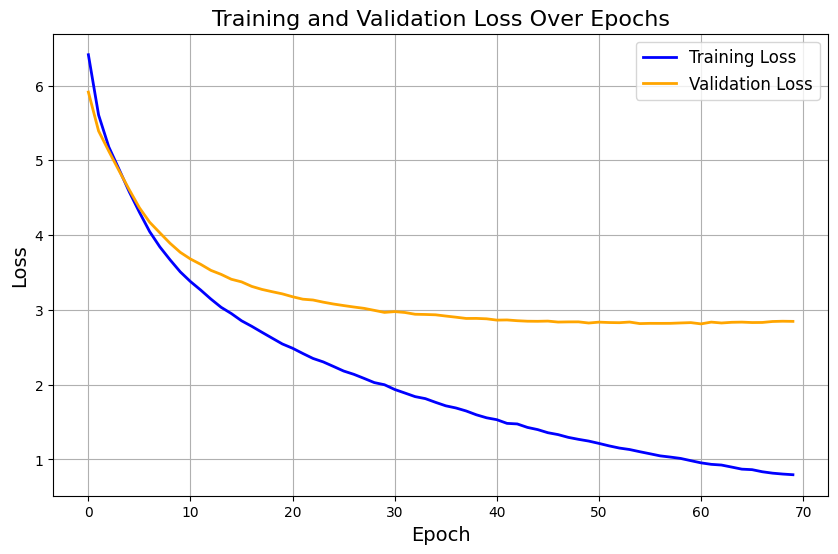

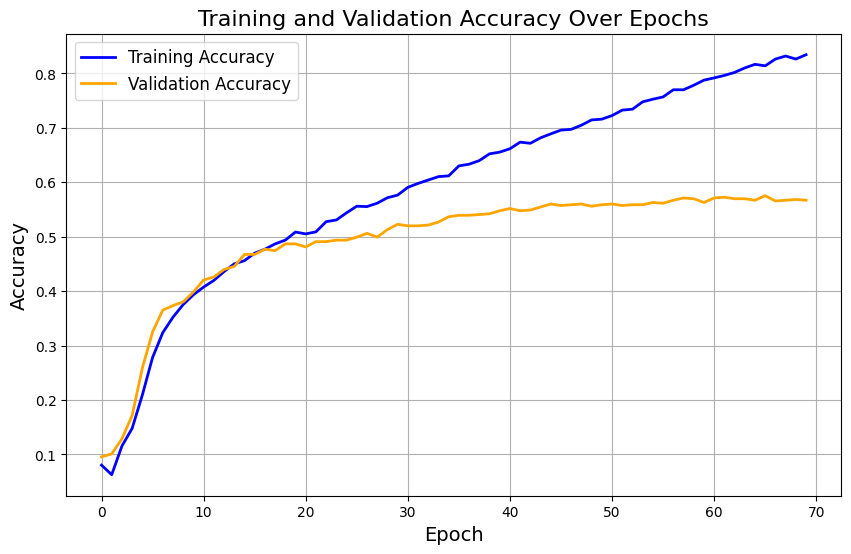

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.